The goal of this notebook is to create a student-teacher model where we first train a teacher on labeled data, and then use this teacher model to label more data, then we swap out the teacher with a student and train again over all the samples. 
- Try AutoAugment/RandAugment
- Add regularization
- Resampling  
  - Make resampling func for unlab_ds
- Create new unlab_ds without previous findings

# Loading data

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import time
import os
import pathlib
import matplotlib.pyplot as plt
 
# Some stuff to make utils-function work
import sys
sys.path.append('../utils')
from pipeline import create_dataset, split_and_create_dataset, prepare_for_training
from utils import show_image, class_distribution, print_split_info, unpipe
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [74]:
data_dir = pathlib.Path('/home/henriklg/master-thesis/data/hyper-kvasir/labeled_ttv/')

conf = {
    # Dataset
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "ds_info": 'hypkva',
    "augment": ["crop","flip","brightness","saturation","contrast","rotate"],
    "resample": False,
    "class_weight": False,
    "shuffle_buffer_size": 2000,        # 0=no shuffling
    "seed": 123,
    "neg_class": None,                 # select neg class for binary ds (normal class)
    "outcast": None,                   # list of folders to drop - currently only works for 1 item
    # Model
    "model": 'EfficientNetB0',
    "num_epochs": 5,
    "batch_size": 128,
    "img_shape": (128, 128, 3),
    "learning_rate": 0.01,
    "optimizer": 'Adam',
    "final_activation": 'softmax',
    # Callbacks
    "learning_schedule": True,
    "decay_rate": 0.1,                 # higher number gives steeper dropoff
    "checkpoint": False,
    "early_stopp": True,
    "early_stopp_patience": 6,
    # Misc
    "verbosity": 1
    }

Create training, testing and validation dataset from utils/data_prep.py.  
Returns tf.dataset for shuffled, cached and batched data

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(conf)

class_names = params["class_names"]

barretts-short-segment      :   53 | 0.50%
retroflex-stomach           :  764 | 7.17%
ulcerative-colitis-0-1      :   35 | 0.33%
ulcerative-colitis-grade-3  :  133 | 1.25%
esophagitis-b-d             :  260 | 2.44%
dyed-resection-margins      :  989 | 9.28%
hemorrhoids                 :    6 | 0.06%
normal-z-line               :  932 | 8.74%
esophagitis-a               :  403 | 3.78%
ulcerative-colitis-1-2      :   11 | 0.10%
barretts                    :   41 | 0.38%
bbps-2-3                    : 1148 | 10.77%
ileum                       :    9 | 0.08%
bbps-0-1                    :  646 | 6.06%
impacted-stool              :  131 | 1.23%
cecum                       : 1009 | 9.46%
ulcerative-colitis-grade-2  :  443 | 4.15%
ulcerative-colitis-2-3      :   28 | 0.26%
pylorus                     :  999 | 9.37%
retroflex-rectum            :  391 | 3.67%
ulcerative-colitis-grade-1  :  201 | 1.89%
polyps                      : 1028 | 9.64%
dyed-lifted-polyps          : 1002 | 9.40%

Total num

In [4]:
datasets = {"train": train_ds.unbatch().take(params["train_size"]),
            "test": test_ds.unbatch().take(params["test_size"]),
            "val": val_ds.unbatch().take(params["val_size"])}

# NB: this will cache the whole dataset
print_split_info(datasets, conf, params)

Category                    : train | test  | val   |  
-------------
barretts-short-segment      :    37 |     8 |     8 | 
retroflex-stomach           :   534 |   115 |   115 | 
ulcerative-colitis-0-1      :    24 |     5 |     6 | 
ulcerative-colitis-grade-3  :    93 |    20 |    20 | 
esophagitis-b-d             :   182 |    39 |    39 | 
dyed-resection-margins      :   692 |   148 |   149 | 
hemorrhoids                 :     4 |     1 |     1 | 
normal-z-line               :   652 |   140 |   140 | 
esophagitis-a               :   282 |    60 |    61 | 
ulcerative-colitis-1-2      :     7 |     2 |     2 | 
barretts                    :    28 |     6 |     7 | 
bbps-2-3                    :   803 |   172 |   173 | 
ileum                       :     6 |     1 |     2 | 
bbps-0-1                    :   452 |    97 |    97 | 
impacted-stool              :    91 |    20 |    20 | 
cecum                       :   706 |   151 |   152 | 
ulcerative-colitis-grade-2  :   310 |    66 |    6

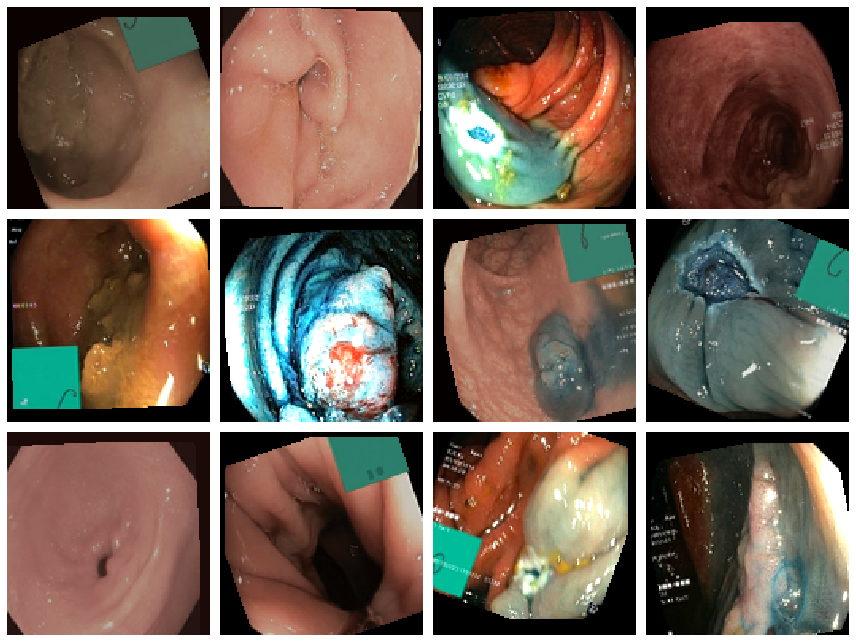

In [5]:
# Show some images from training dataset (mainly to check augmentation)
batch = next(iter(train_ds))
images, labels = batch
images = images.numpy()

nrows, ncols = 3, 4  # array of sub-plots
figsize = [ncols*3, nrows*3]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=figsize, frameon=False, facecolor='white')

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    img = images[i]
    axi.imshow(img)
    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    # write row/col indices as axes' title for identification
    #axi.set_title("Row:"+str(rowid)+", Col:"+str(colid))
    axi.set_axis_off()

plt.axis('off')
plt.tight_layout(True)
# plt.savefig("{}/unlab_data_checkout-{}.pdf".format(log_dir, checkout), format='pdf')
plt.show()

# Step 1: Train a teacher model on labeled images

In [6]:
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers

### Create and compile the model

In [7]:
if conf["model"] == 'EfficientNetB0': 
    from efficientnet import EfficientNetB0 as EfficientNet # 5.3M params
elif conf["model"] == 'EfficientNetB1': 
    from efficientnet import EfficientNetB1 as EfficientNet # 7.8M params
elif conf["model"] == 'EfficientNetB2':
    from efficientnet import EfficientNetB2 as EfficientNet # 9.2M params
elif conf["model"] == 'EfficientNetB3':
    from efficientnet import EfficientNetB3 as EfficientNet # 12M params

Using TensorFlow backend.


In [8]:
efficientnet_base = EfficientNet(
    weights="imagenet",
    include_top=False, 
    input_shape=conf["img_shape"]
)

# Unfreeze the layers. I.E we're just using the pre-trained weights as initial weigths and biases and train over them
efficientnet_base.trainable = True


# Define model
teacher_model = Sequential()
teacher_model.add(efficientnet_base)
teacher_model.add(layers.GlobalAveragePooling2D())
teacher_model.add(layers.Dropout(0.3))
teacher_model.add(layers.Dense(512, activation='relu'))
teacher_model.add(layers.Dropout(0.3))
teacher_model.add(layers.Dense(params["num_classes"], activation=conf["final_activation"]))



# from keras import regularizers

# teacher_model = Sequential()
# teacher_model.add(efficientnet_base)
# teacher_model.add(layers.GlobalAveragePooling2D())
# teacher_model.add(layers.Dropout(0.5))
# teacher_model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
#                                activation='relu'))
# teacher_model.add(layers.Dropout(0.5))
# teacher_model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
#                                activation='relu'))
# teacher_model.add(layers.Dropout(0.4))
# teacher_model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001),
#                                activation='relu'))
# teacher_model.add(layers.Dropout(0.3))
# teacher_model.add(layers.Dense(params["num_classes"], activation=conf["final_activation"]))



if conf['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=conf["learning_rate"])
elif conf['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=conf["learning_rate"])

teacher_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

teacher_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 4, 4, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                11799     
Total params: 4,717,235
Trainable params: 4,675,219
Non-trainable params: 42,016
_________________________________________

### Callbacks

In [9]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import datetime

# By using LearnignRateScheduler
initial_learning_rate = conf["learning_rate"]
decay_steps = params["train_size"] // conf["batch_size"]
batch_size = conf['batch_size']
decay_rate = conf['decay_rate']

def schedule(epoch):
    # calculate new learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * (epoch*batch_size) / decay_steps)
    
    # update tensorboard
    tf.summary.scalar(name='learning_rate', data=learning_rate, step=epoch)
    return learning_rate

log_dir="./logs/{}/".format(conf["model"]) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()

lr_schedule_cb = LearningRateScheduler(schedule, verbose=1)
earlystopp_cb = EarlyStopping(monitor='val_loss', 
                              verbose=1, patience=conf["early_stopp_patience"], 
                              restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(filepath='./models/best_cp-{epoch:03d}.hdf', 
                                monitor='val_loss', save_best_only=True, mode='auto')
tensorboard_cb = TensorBoard(log_dir=log_dir, update_freq='batch')

callbacks = [tensorboard_cb]
if conf["early_stopp"]: callbacks.append(earlystopp_cb)
if conf["learning_schedule"]: callbacks.append(lr_schedule_cb)
if conf["checkpoint"]: callbacks.append(checkpoint_cb)

# Write conf and params dictionary to text file
list_of_strings = [ '{:20} : {}'.format(key, conf[key]) for key in conf ]
with open(log_dir+"/conf.txt","w") as f:
    [ f.write(f'{st}\n') for st in list_of_strings ]
f.close()

f = open(log_dir+"/params.txt","w")
f.write(str(params))
f.close()

#### Class weight

In [10]:
class_weights = None

if conf["class_weight"]:
    assert not conf["resample"], "Should only use resample or class_weight. Not both."
    
    from utils import calculate_weights

    class_weights = calculate_weights(
        train_ds.unbatch().take(params["train_size"]), 
        num_classes=params["num_classes"]
    )

    class_weights = dict(enumerate(class_weights))
    print ("Class weights:")
    print (class_weights)

### Train the teacher model

In [11]:
start_time = time.time()
try: 
    history = teacher_model.fit(
        train_ds,
        steps_per_epoch = params["train_size"] // conf["batch_size"],
        epochs = conf["num_epochs"],
        validation_data = test_ds,
        validation_steps = params["test_size"] // conf["batch_size"],
        validation_freq = 1,
        class_weight = class_weights,
        callbacks = callbacks,
        verbose = 1
    )
except KeyboardInterrupt:
    print ("exiting")
    
finally:
    print ("Time spent on training: {}".format(time.time() - start_time))

# Save the metrics from training
f = open(log_dir+"/history.txt","w")
f.write(str(history.history))
f.close()

Train for 58 steps, validate for 12 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/5
58/58 [==============================] - 24s 418ms/step - loss: 1.5901 - sparse_categorical_accuracy: 0.5330 - val_loss: 7869.7279 - val_sparse_categorical_accuracy: 0.0612

Epoch 00002: LearningRateScheduler reducing learning rate to 0.008192090395480226.
Epoch 2/5
58/58 [==============================] - 16s 274ms/step - loss: 0.8480 - sparse_categorical_accuracy: 0.7068 - val_loss: 15.8417 - val_sparse_categorical_accuracy: 0.0723

Epoch 00003: LearningRateScheduler reducing learning rate to 0.006937799043062201.
Epoch 3/5
58/58 [==============================] - 16s 275ms/step - loss: 0.6998 - sparse_categorical_accuracy: 0.7676 - val_loss: 15.6049 - val_sparse_categorical_accuracy: 0.1361

Epoch 00004: LearningRateScheduler reducing learning rate to 0.006016597510373444.
Epoch 4/5
58/58 [==============================] - 16s 276ms/step - loss: 0.5813 - sparse_cat

### Save or restore a model

In [12]:
# Save the model
model_name = '{}x{}x{}_{}_{}'.format(conf["num_epochs"], conf["batch_size"], 
                                     conf["img_shape"][1], conf["ds_info"], conf["model"])
best_acc =  str(history.history["val_sparse_categorical_accuracy"][-1])[2:4]
teacher_model.save(log_dir+'/{}.h5'.format(model_name+'_'+best_acc))

## Evaluate the model

In [13]:
from model_evaluation import display_classification_report
from model_evaluation import get_metrics
from model_evaluation import get_confusion_matrix
from model_evaluation import plot_confusion_matrix

In [14]:
eval_ds = unpipe(test_ds, params["test_size"]).as_numpy_iterator()
eval_ds = np.array(list(eval_ds))
eval_images = np.stack(eval_ds[:,0], axis=0)

true_labels = list(eval_ds[:,1])

predictions = teacher_model.predict(eval_images, verbose=1)

predicted_confidence = [np.max(pred) for pred in predictions]
predicted_labels = [np.argmax(pred) for pred in predictions]

1598/1598 [==============================] - 2s 1ms/sample


In [15]:
get_metrics(true_labels, predicted_labels)

Accuracy: 0.7021
Precision: 0.6991
Recall: 0.7021
F1 Score: 0.6702


/home/henriklg/anaconda3/envs/TF2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
display_classification_report(
        true_labels, 
        predicted_labels, 
        range(params["num_classes"]), 
        target_names=params["class_names"]
)

                            precision    recall  f1-score   support

    barretts-short-segment      0.000     0.000     0.000         8
         retroflex-stomach      1.000     0.600     0.750       115
    ulcerative-colitis-0-1      0.000     0.000     0.000         5
ulcerative-colitis-grade-3      0.000     0.000     0.000        20
           esophagitis-b-d      0.778     0.179     0.292        39
    dyed-resection-margins      0.898     0.770     0.829       148
               hemorrhoids      0.000     0.000     0.000         1
             normal-z-line      0.546     0.421     0.476       140
             esophagitis-a      0.000     0.000     0.000        60
    ulcerative-colitis-1-2      0.000     0.000     0.000         2
                  barretts      0.000     0.000     0.000         6
                  bbps-2-3      0.754     1.000     0.860       172
                     ileum      0.000     0.000     0.000         1
                  bbps-0-1      1.000     0.588

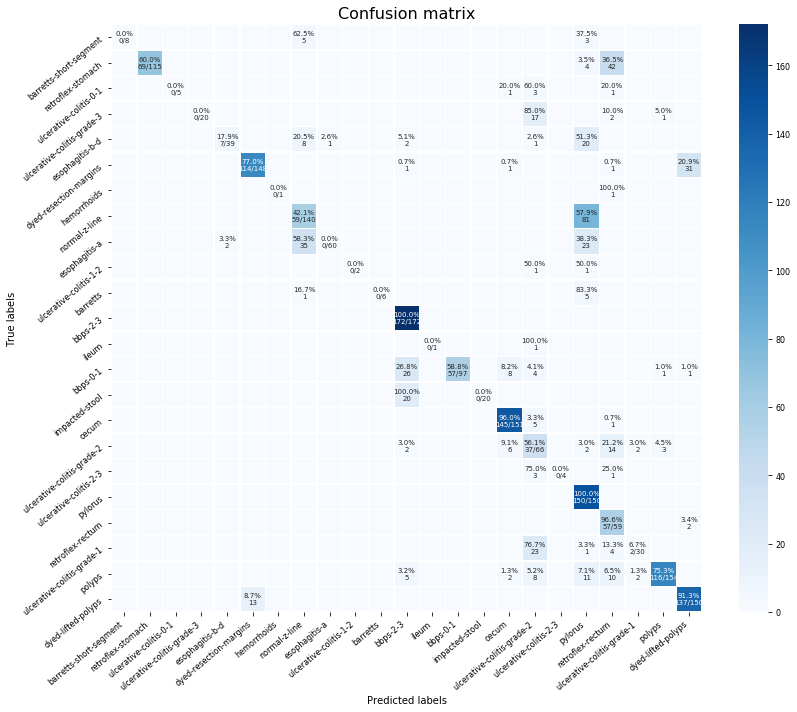

In [110]:
cm = get_confusion_matrix(true_labels, predicted_labels)
import seaborn as sns

plot_confusion_matrix(cm, log_dir, params["class_names"], figsize=(12,10))

In [18]:
# Check if validation data is cached
cache_dir = conf["cache_dir"]
img_width = conf["img_shape"][0]
ds_info = conf["ds_info"]
filename = "{}/{}_{}_val.tfcache.index".format(cache_dir, img_width, ds_info)

cached = os.path.isfile(filename)
if not cached:
    # Iterate over dataset to initialize caching
    for batch in val_ds.take( (params["val_size"]//conf["batch_size"])+1 ):
        pass

In [19]:
teacher_evaluate = teacher_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // conf["batch_size"])

# Write evaluate dictionary to text file
f = open(log_dir+"/val_evaluate.txt","w")
f.write( str(teacher_evaluate) )
f.close()

12/12 - 1s - loss: 1.7216 - sparse_categorical_accuracy: 0.6908


In [20]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

if conf["learning_schedule"]: lr = history.history['lr']
epochs_range = range(history.epoch[-1]+1)

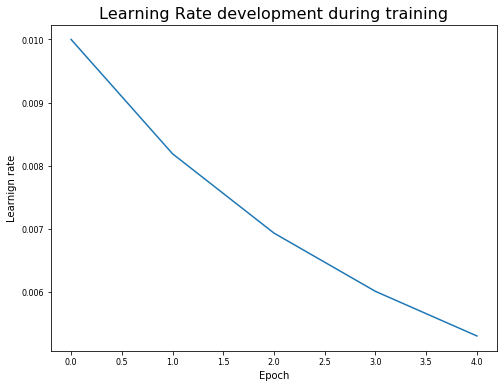

In [21]:
if conf["learning_schedule"]:
    # Plot the learning rate
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, lr, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learnign rate')
    plt.title('Learning Rate development during training');
    plt.savefig(log_dir+'/learning_rate.pdf', format='pdf')

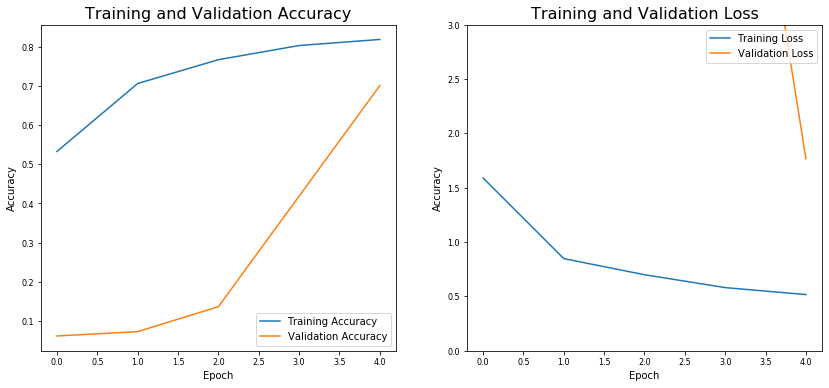

In [22]:
# Plot train-val accuracy and loss
plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim([0.0, 3])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.savefig(log_dir+'/accuracy_and_loss.pdf', format='pdf')
plt.show()

Display grid of some random samples from validation data with the prediction confidence

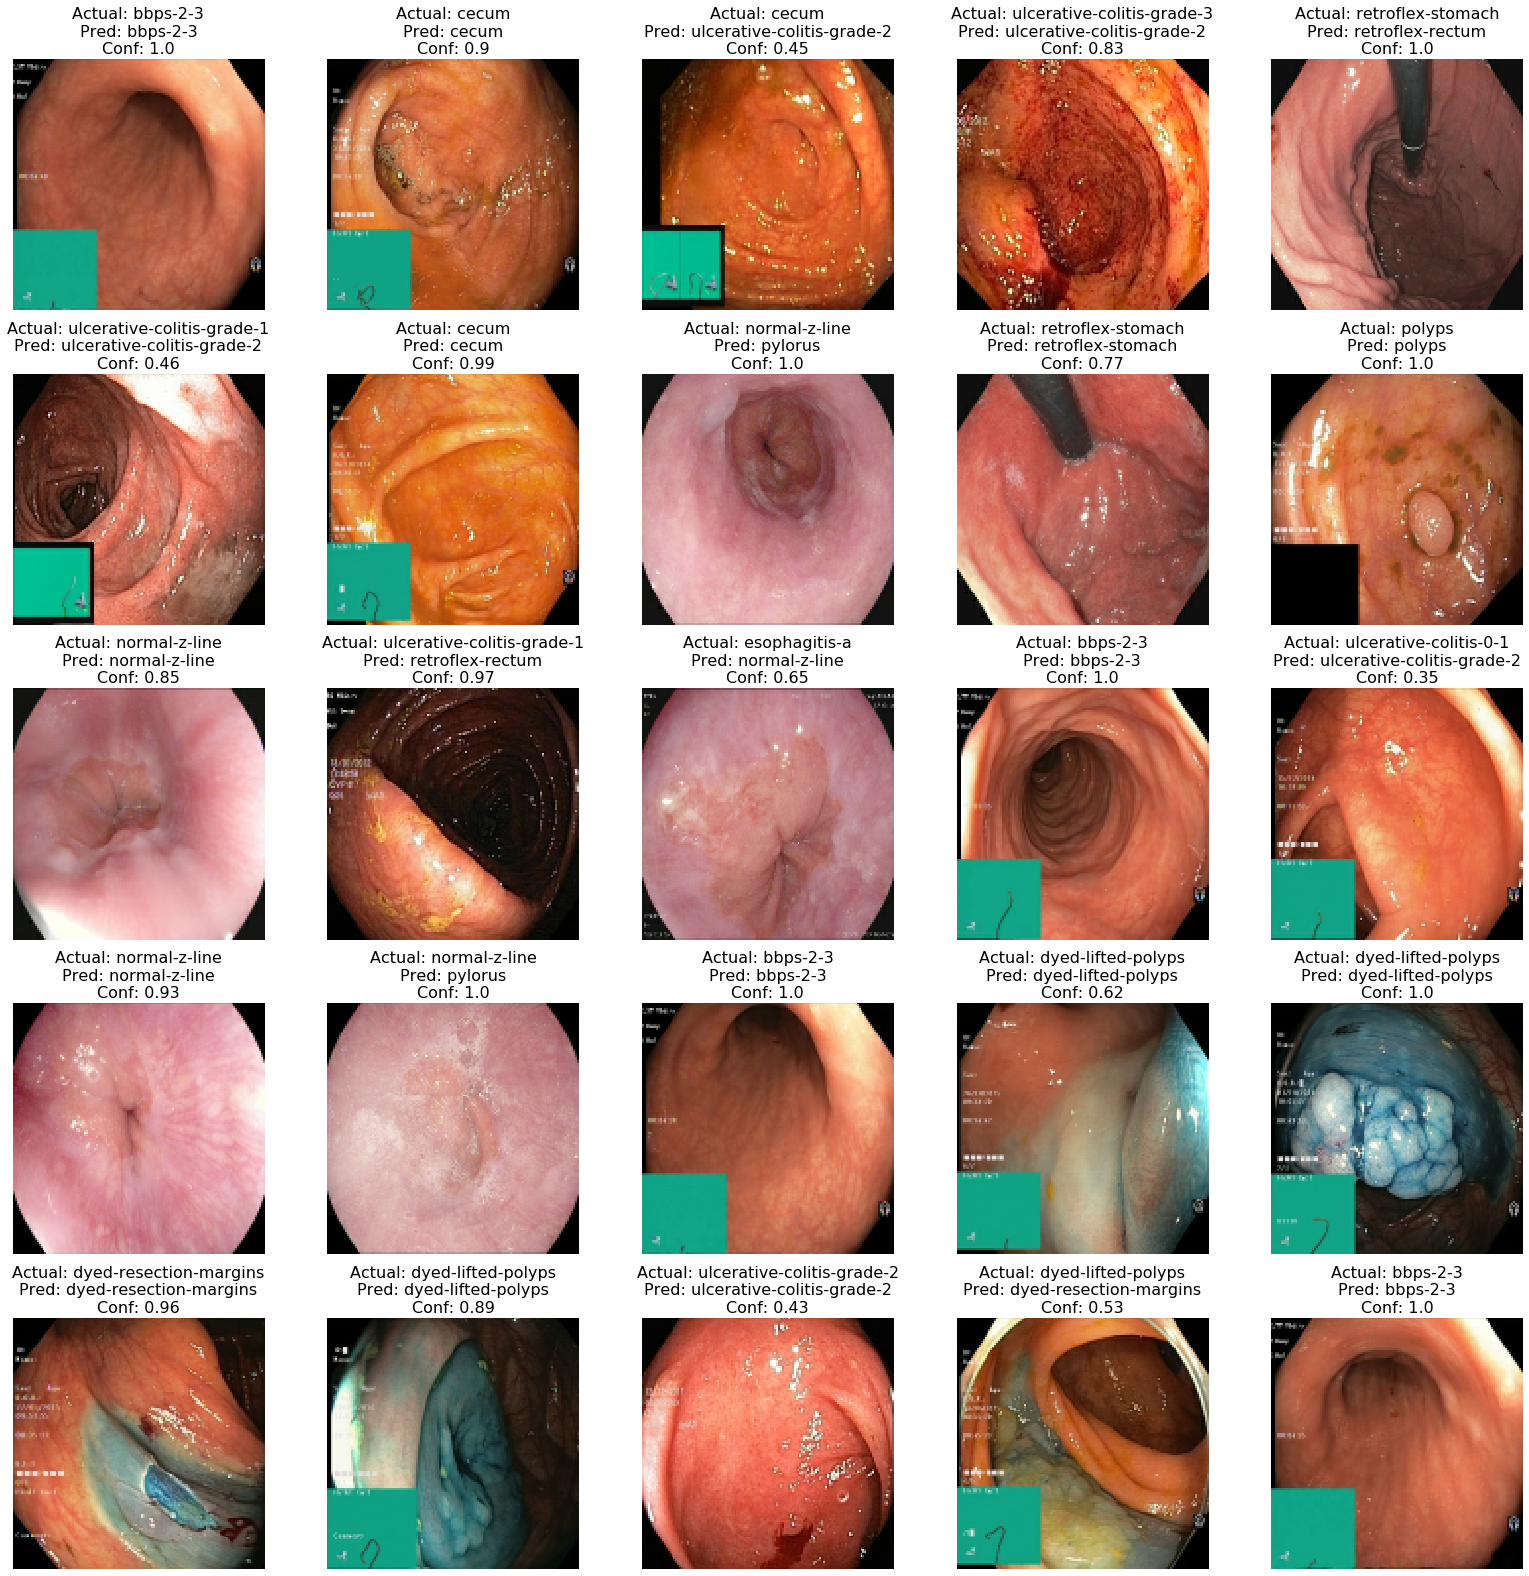

In [73]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(22, 22)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        actual = params["class_names"][true_labels[img_idx]]
        lab = params["class_names"][predicted_labels[img_idx]]
        pred = np.round(predicted_confidence[img_idx], 2)
        
        title = 'Actual: '+actual+'\nPred: '+lab+ '\nConf: '+str(pred)
        ax[i][j].axis('off')
        ax[i][j].set_title(title)
        ax[i][j].imshow(eval_images[img_idx])
        img_idx += 1

plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0.5, hspace=0.5)
plt.tight_layout()
plt.savefig(log_dir+"/model_predictions-val.pdf", format="pdf")

### Test: run prediction on images from the validation dataset

### Test: run prediction on images from the unlabeled_test dataset
(which are images taken from the training data)  
TODO: just remove this?

# Step 2: use the teacher to generate pseudo labels on unlabeled images

### Read in the unlabeled dataset

In [111]:
def get_filename(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # the last item of parts is the filename
    filename = parts[-1]
    return filename

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img) # had to remove channels=3 paramter..
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [ conf["img_shape"][0], conf["img_shape"][1] ])

def process_path(file_path):
    filename = get_filename(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, filename

In [112]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
data_dir_unlabeled = pathlib.Path('/home/henriklg/master-thesis/data/hyper-kvasir/unlabeled_ttv/')

ds_size_unlabeled = len(list(data_dir_unlabeled.glob('*.*g')))

files_string = str(data_dir_unlabeled/'*.*g')
list_ds_unlabeled = tf.data.Dataset.list_files(
        files_string, 
        shuffle=conf["shuffle_buffer_size"]>1, 
        seed=tf.constant(conf["seed"], tf.int64)
)

unlabeled_ds = list_ds_unlabeled.map(process_path, num_parallel_calls=AUTOTUNE)

print ("Loaded {} images into unlabeled_ds.".format(ds_size_unlabeled))

Loaded 99417 images into unlabeled_ds.


File: b79fd89e-6dc5-4ff9-bc5b-2da4900b8479.jpg

97.62% retroflex-rectum
 1.60% polyps


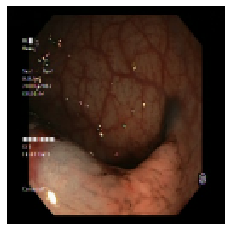

In [113]:
# Run prediction on 1 image
#img, name = next(iter(unlabeled_ds))

for img, name in unlabeled_ds.take(1):

    print ("File:",str(name.numpy())[2:-1], end='\n\n')
    show_image(img.numpy())

    # Add dimension and predict
    img = np.expand_dims(img.numpy(), 0)
    prediction = teacher_model.predict(img, verbose=0)

    # If probability above 1% print info
    for i, pred in enumerate(prediction[0]):
         if pred > 0.01: print("{:>5.2f}% {}".format(pred*100, class_names[i]))

## Run predictions on all unlabeled images
Using 'append to list and convert to tensor'-method

In [281]:
from IPython.display import clear_output
from tqdm.notebook import tqdm
from utils import print_bar_chart

pred_confidence = 0.75
new_findings = 0
count = 0
img_list = []
lab_list = []
pred_list = []

In [ ]:
total_time = time.time()

tqdm_predicting = tqdm(total=ds_size_unlabeled, desc='Predicting', position=0, initial=count)
tqdm_findings = tqdm(total=ds_size_unlabeled, desc='Findings', 
                     position=1, bar_format='{desc}:{bar}{n_fmt}', initial=new_findings)

print ("Press 'Interrupt Kernel' to save and exit.")
try:
    for count, (image,path) in enumerate(unlabeled_ds, start=count):
        img = np.expand_dims(image, 0)
        pred = teacher_model.predict(img)
        highest_pred = np.max(pred)
        if highest_pred > pred_confidence:
            pred_idx = np.argmax(pred).astype(np.int32)

            img_list.append(image)
            lab_list.append(pred_idx)
            pred_list.append(highest_pred)
            
            # Generate bar chart and refresh the tqdm progress bars
            if not new_findings%500:
                clear_output(wait=True)
                tqdm_predicting = tqdm(total=ds_size_unlabeled, desc='Predicting', position=0, initial=count)
                tqdm_findings = tqdm(total=ds_size_unlabeled, desc='Findings', 
                     position=1, bar_format='{desc}:{bar}{n_fmt}', initial=new_findings)
                print_bar_chart(lab_list, new_findings, count, params)
                
            new_findings += 1
            tqdm_findings.update(1)
        tqdm_predicting.update(1)
except KeyboardInterrupt:
    print ("Exiting")

finally:
    print ("\nTotal run time: {:.3f} s".format( time.time() - total_time ))
    print ("Found {} new samples in unlabeled_ds after looking at {} images.".format(new_findings, count))

In [ ]:
# Save the bar chart
print_bar_chart(lab_list, new_findings, count, params, log_dir=log_dir, figsize=(15,10))
clear_output(wait=False)

Save the image and labels list as pickle dump

## Inspect the classified images

### Sort new samples after confidence

In [ ]:
from utils import custom_sort

pred_list, lab_list, img_list = custom_sort(pred_list, lab_list, img_list)

In [284]:
sorted_list = list(zip(pred_list, lab_list, img_list))

In [285]:
sorted_list.sort(key=lambda x: x[0], reverse=True)

In [287]:
pred_list_sorted = [row[0] for row in sorted_list]
lab_list_sorted = [row[1] for row in sorted_list]
img_list_sorted = [row[2] for row in sorted_list]

### Display samples from all classes
Create label images

In [288]:
# Create images with label names
from PIL import Image, ImageDraw, ImageFont
import textwrap

class_label_img = []
font_path = '/usr/share/fonts/truetype/ubuntu/UbuntuMono-B.ttf'
# img_width = conf["img_shape"][0]
img_width = 512
font_size = int(img_width*0.15)
# print ('font size:',font_size)
letters_per_line = 13

for i in range(params["num_classes"]):
    img = Image.new('RGB', (img_width, img_width), color = (0, 0, 0))
    fnt = ImageFont.truetype(font_path, font_size)
    d = ImageDraw.Draw(img)
    if (len(class_names[i])>letters_per_line):
        text = textwrap.fill(class_names[i], width=letters_per_line)
    else:
        text = class_names[i]
    linebreaks = text.count('\n')
    d.text((1,(img_width//2.2)-linebreaks*img_width*0.1), text, font=fnt, fill=(255, 255, 255))
    
#     show_image(img)
    class_label_img.append(img)

Create a list containing 6 images from each predicted class

In [297]:
# create a list[num_classes] with 6 sample images per class
# TODO: ADD SHUFFLING

# black image
img_black = Image.new('RGB', (conf["img_shape"][0], conf["img_shape"][1]), color = (0, 0, 0))

class_examples = []
class_preds = []
for class_idx in range(params["num_classes"]):
    curr_class_examples = []
    curr_class_preds = []
    
    indekser = np.where(np.asarray(lab_list_sorted, dtype=np.int64)==class_idx)[0]
    for i in range(6):
        # get 6 finding images from class_idx-class
        # no image - index out of bounds
        if not indekser.size > i:
            curr_class_examples.append(img_black)
            curr_class_preds.append(0)
        # found image
        else:
            curr_class_examples.append(img_list_sorted[indekser[i]])
            curr_class_preds.append(pred_list_sorted[indekser[i]])
        
    class_examples.append(curr_class_examples)
    class_preds.append(curr_class_preds)

assert (len(class_names)==len(class_examples)), 'must be same length'

Display the predicted images in each class

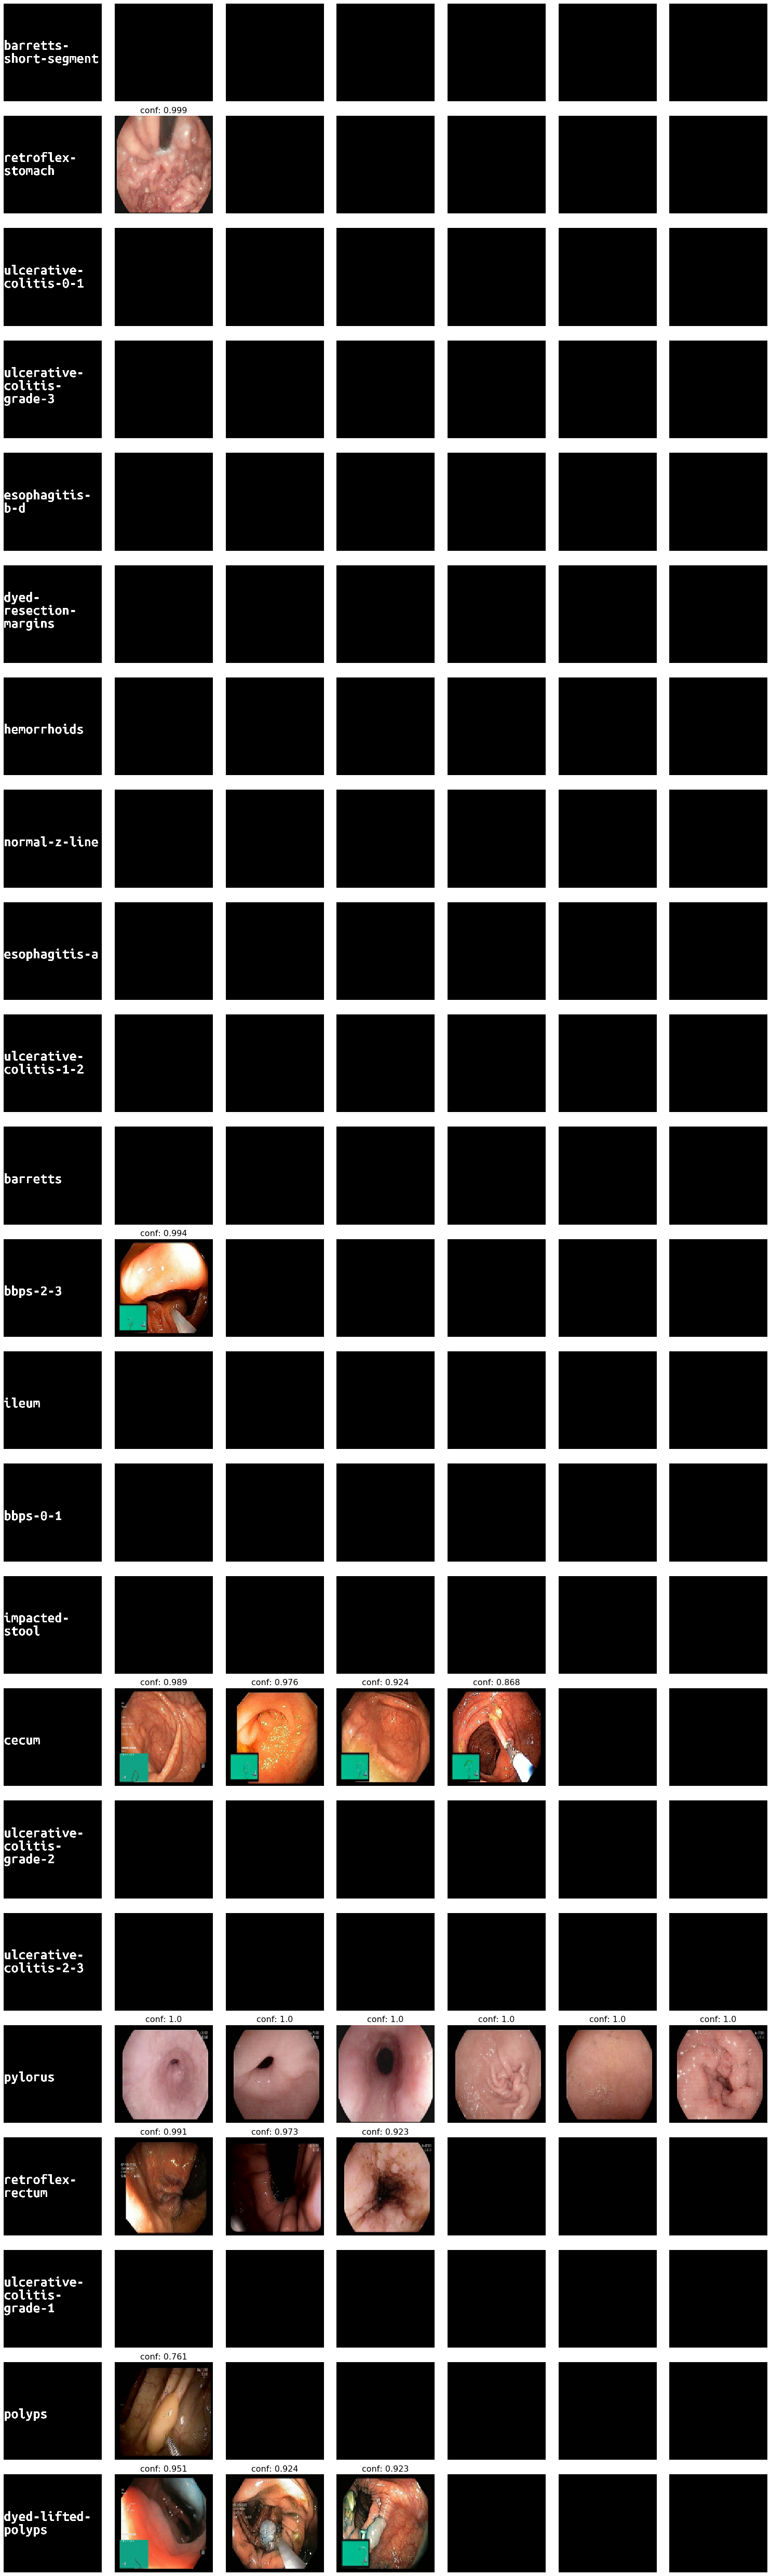

In [298]:
# settings
nrows, ncols = params["num_classes"], 7  # array of sub-plots
figsize = [ncols*3, params["num_classes"]*3]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=figsize, frameon=False, facecolor='white')

# plot simple raster image on each sub-plot
try:
    for i, axi in enumerate(ax.flat):
        # i runs from 0 to (nrows*ncols-1)
        # axi is equivalent with ax[rowid][colid]
        rowid = i // ncols
        colid = i % ncols
        
        if colid == 0:
            img = class_label_img[rowid]
        else:
            pred = class_preds[rowid][colid-1]
            title = "conf: "+str(round(pred, 3))
            if pred: axi.set_title(title)
            img = class_examples[rowid][colid-1]
        axi.imshow(img)
        
        axi.set_axis_off()
except IndexError:
    pass

plt.axis('off')
plt.tight_layout(True)
plt.savefig("{}/unlab_data_checkout-{}.pdf".format(log_dir, 'all'), format='pdf')
plt.show()

## Print grid of images from one of the classes

In [ ]:
# The class we want to show images from
checkout = 'pylorus'
# checkout = 'polyps'
# checkout = 'normal-z-line'

# Which class number correspond to that class name
idx = np.where(class_names == checkout)[0][0]
# List of img_list-indexes with images corresponding to that class number
idx_list = np.where(lab_list == idx)[0]

# This should be a function

# settings
nrows, ncols = 4, 6  # array of sub-plots
figsize = [15, 10]     # figure size, inches


# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=figsize, frameon=False, facecolor='white')

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    img = img_list[idx_list[i]]
    axi.imshow(img)
    # get indices of row/column
    rowid = i // ncols
    colid = i % ncols
    # write row/col indices as axes' title for identification
    #axi.set_title("Row:"+str(rowid)+", Col:"+str(colid))
    axi.set_axis_off()

plt.axis('off')
plt.tight_layout(True)
plt.savefig("{}/unlab_data_checkout-{}.pdf".format(log_dir, checkout), format='pdf')
plt.show()

### Convert image and label lists to tensors and combine with training_ds to create a new dataset

In [ ]:
findings_tensor = tf.data.Dataset.from_tensor_slices((img_list, lab_list))

In [ ]:
# combine with old ds
combined_ds = train_ds.unbatch().take(params["train_size"]).concatenate(findings_tensor)

# Step 3: Train a student model on the combination of labeled images and pseudo labeled images

Now we have trained a teacher model, and used that model to predict on unlabeled dataset to create more samples with psudo-labels.  
It's time for swapping the teacher with the student!

In [ ]:
combined_ds = prepare_for_training(
        combined_ds, 
        conf["batch_size"], 
        cache=None,
        shuffle_buffer_size=0
    )

In [ ]:
# Unfreeze the layers. I.E we're just using the pre-trained weights as initial weigths and biases and train over them
efficientnet_base.trainable = True

# Define model
stud_model = Sequential()
stud_model.add(efficientnet_base)
stud_model.add(layers.GlobalAveragePooling2D())
# add Dense layer and dropout?
stud_model.add(layers.Dense(params["num_classes"], activation=conf["final_activation"]))

if conf['optimizer'] == 'Adam':
    opt = tf.keras.optimizers.Adam(learning_rate=conf["learning_rate"])
elif conf['optimizer'] == 'SGD':
    opt = tf.keras.optimizers.SGD(learning_rate=conf["learning_rate"])

stud_model.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [ ]:
history = stud_model.fit(
    combined_ds,
    steps_per_epoch = params["train_size"]+new_samples_counter // conf["batch_size"], # might have to reduce
    epochs = 2,
    validation_data = test_ds, # what to use for validation data?
    validation_steps = params["test_size"] // conf["batch_size"],
    validation_freq = 1,
    callbacks = callbacks
)

# Step 4: Iterate this algorithm a few times by treating the student as a teacher to relabel the unlabeled data and training a new student